# Predicting Minutes Taken for Different Recipes

**Name(s)**: Bryan Cha, Chloe Kim

**Website Link**: https://sek034.github.io/Predicting-Minutes-Taken-for-Different-Recipes/

## Code

In [140]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pd.options.plotting.backend = 'plotly'


### Framing the Problem

#### <u>__Prediction Problem__: Predicting Minutes Taken for Different Recipes<u>

#### How we cleaned the data:
Since we are predicting minutes based on the different recipes, there was no need to merge the <u>recipes.csv</u> data with <u>interactions.csv</u> data, since
that would just give us duplicate rows of the exact same recipe. <br>

Data Cleaning Steps: </br>
- Sliced out only the data that is intuitive and relevant to our predictive analysis <br>
- While each element in the **minutes** column in <u>recipes.csv</u> is an integer, time in general
is a continuous variable; therefore, I converted it to type ```np.float64``` to better aid my prediction 
problem.
- The table below shows the resulting columns that I am using for my predictive analysis: <br>

|Column Name     |Description                                     |dtype         |
|----------------|------------------------------------------------|--------------|
|name            |Name of each Recipe                             |```object```  |
|n_steps         |# of steps involved in making recipe            |```int64```   |
|steps           |Description of steps involved in making the food|```object```  |
|n_ingredients   |# of ingredients involved in making the food    |```int64```   |
|ingredients     |Ingredients involved in making the food         |```object```  | 
|minutes         |Time taken to carry out the recipe              |```float64``` | 

- Since each element in the **ingredients** and **steps** columns are a list in string format,
I handled it by joining all the comma-separated strings into a single string so that it is possible to
use a tdidf-vectorizer to create new features later. I also removed any extra spaces to ensure proper parsing
and consistency. <br>

This results in the following DataFrame: <br>
|    | name                                 |   n_steps | steps                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |   n_ingredients | ingredients                                                                                                                                                                                                 |   minutes |
|---:|:-------------------------------------|----------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------:|
|  0 | 1 brownies in the world    best ever |        10 | heat the oven to 350f and arrange the rack in the middle  line an 8-by-8-inch glass baking dish with aluminum foil  combine chocolate and butter in a medium saucepan and cook over medium-low heat   stirring frequently   until evenly melted  remove from heat and let cool to room temperature  combine eggs   sugar   cocoa powder   vanilla extract   espresso   and salt in a large bowl and briefly stir until just evenly incorporated  add cooled chocolate and mix until uniform in color  add flour and stir until just incorporated  transfer batter to the prepared baking dish  bake until a tester inserted in the center of the brownies comes out clean   about 25 to 30 minutes  remove from the oven and cool completely before cutting                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |               9 | bittersweet chocolate  unsalted butter  eggs  granulated sugar  unsweetened cocoa powder  vanilla extract  brewed espresso  kosher salt  all-purpose flour                                                  |        40 |
|  1 | 1 in canada chocolate chip cookies   |        12 | pre-heat oven the 350 degrees f  in a mixing bowl   sift together the flours and baking powder  set aside  in another mixing bowl   blend together the sugars   margarine   and salt until light and fluffy  add the eggs   water   and vanilla to the margarine / sugar mixture and mix together until well combined  add in the flour mixture to the wet ingredients and blend until combined  scrape down the sides of the bowl and add the chocolate chips  mix until combined  scrape down the sides to the bowl again  using an ice cream scoop   scoop evenly rounded balls of dough and place of cookie sheet about 1 - 2 inches apart to allow for spreading during baking  bake for 10 - 15 minutes or until golden brown on the outside and soft & chewy in the center  serve hot and enjoy !                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |              11 | white sugar  brown sugar  salt  margarine  eggs  vanilla  water  all-purpose flour  whole wheat flour  baking soda  chocolate chips                                                                         |        45 |\n|  2 | 412 broccoli casserole               |         6 | preheat oven to 350 degrees  spray a 2 quart baking dish with cooking spray   set aside  in a large bowl mix together broccoli   soup   one cup of cheese   garlic powder   pepper   salt   milk   1 cup of french onions   and soy sauce  pour into baking dish   sprinkle remaining cheese over top  bake for 25 minutes or until cheese is lightly browned  sprinkle with rest of french fried onions and bake until onions are browned and cheese is bubbly   about 10 more minutes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |               9 | frozen broccoli cuts  cream of chicken soup  sharp cheddar cheese  garlic powder  ground black pepper  salt  milk  soy sauce  french-fried onions                                                           |        40 |\n|  3 | millionaire pound cake               |         7 | freheat the oven to 300 degrees  grease a 10-inch tube pan with butter   dust the bottom and sides with flour   and set aside  in a large mixing bowl   cream the butter and sugar with an electric mixer and add the eggs one at a time   beating after each addition  alternately add the flour and milk   stirring till the batter is smooth  add the two extracts and stir till well blended  scrape the batter into the prepared pan and bake till a cake tester or knife blade inserted in the center comes out clean   about 1 1 / 2 hours  cool the cake in the pan on a rack for 5 minutes   then turn it out on the rack to cool completely                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |               7 | butter  sugar  eggs  all-purpose flour  whole milk  pure vanilla extract  almond extract                                                                                                                    |       120 |
|  4 | 2000 meatloaf                        |        17 | pan fry bacon   and set aside on a paper towel to absorb excess grease  mince yellow onion   red bell pepper   and add to your mixing bowl  chop garlic and set aside  put 1tbsp olive oil into a saut pan   along with chopped garlic   teaspoons white pepper and a pinch of kosher salt  bring to a medium heat to sweat your garlic  preheat oven to 350f  coarsely chop your baby spinach add to your heated pan   stir frequently for approximately 5 min to wilt  add your spinach to the mixing bowl  chop your now cooled bacon   and add it to the mixing bowl  add your meatloaf mix to the bowl   with one egg and mix till thoroughly combined  add your goat cheese   one egg   1 / 8 tsp white pepper and 1 / 8 tsp of kosher salt and mix till thoroughly combined  transfer to a 9x5 meatloaf pan   and cook for 60 min or until the internal temperature is at least 160f  let stand for 5min  melt 1tbsp unsalted butter into a frying pan   and cook up to three eggs at a time  crack each egg into a separate dish   in order to prevent egg shells from reaching the pan   then add salt and pepper to taste  wait until the egg whites are firm looking   but slightly runny on top before flipping your eggs  after flipping   wait 10~20 seconds before removing each egg and placing it over your slices of meatloaf |              13 | meatloaf mixture  unsmoked bacon  goat cheese  unsalted butter  eggs  baby spinach  yellow onion  red bell pepper  simply potatoes shredded hash browns  fresh garlic  kosher salt  white pepper  olive oil |        90 |

__Dependent Variable__: I chose **minutes** as the dependent variable because it is a <u>quantitative continuous</u> variable, which makes it a good target for regression. While the data seemingly only provides integers values for minutes, time is ultimately a continuous variable, which makes it more feasible to predict if converted to a floating value. In a real-world context, restaurants can use this predictive model to plan out feasible menus and individuals will be able to estimate and manage their time in the kitchen, making this predictive analysis useful in time management situations, or even for food and beverage businesses where menu planning might be required.

__Evaluation Metric__: For a regression problem like mine, metrics like mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE) come to mind. I will be using the **Mean absoute Error**, since this metric is easy to understand and robust to outliers.

__Known Information at Time of Prediction__: For predicting calories, the **n_steps** and **n_ingredients** will already be known at the time of prediction, since the ingredients themselves are already available and the number of steps have to occur before the time is calculated, which means that it is feasible to use these features for minute prediction.

In [141]:
# TODO
### Helper Functions
def transform_text(df, col_names=['ingredients']):
    ''' 
    receives an DataFrame-like object and a column name
    and combines all the text in the given column into a single string
    '''
    df_copy = df.copy(deep=True)
    for col in col_names:
        df_copy[col] = df_copy[col].apply(lambda x: re.sub(r'\W{2,}', " ", ' '.join(x.lower().strip('[]').replace('\'', "").split(','))))
    
    return df_copy

def transform_calories(df):
    ''' 
    receives an DataFrame-like object and a column name
    and combines all the text in the given column into a single string
    '''
    df_copy = df.copy(deep=True)
    df_copy['calories'] = df_copy['nutrition'].apply(lambda x: x.strip('[]').split(',')[0]).astype(np.float64)
        
    return df_copy.drop('nutrition', axis=1)

def IQR_filtering(df):
    df_copy = df.copy(deep=True)
    Q1 = df['calories'].quantile(0.25)
    Q3 = df['calories'].quantile(0.75)
    IQR = Q3-Q1
    
    df_filtered = df_copy[(Q1-1.5*IQR < df['calories']) & (Q3 + 1.5*IQR > df['calories'])]
    
    return df_filtered
    

In [142]:
recipes = pd.read_csv('RAW_recipes.csv')
# interactions = pd.read_csv('./food_data/RAW_interactions.csv')
df = recipes
# df = pd.merge(interactions, recipes, left_on='recipe_id', right_on='id')
food_data = df.copy(deep=True)[['name','n_steps', 'steps', 'n_ingredients', 'ingredients', 'nutrition', 'minutes']]
food_data = transform_text(food_data, ['ingredients', 'steps'])
food_data = transform_calories(food_data)
food_data = IQR_filtering(food_data)
food_data['minutes'] = food_data['minutes'].astype(np.float64)
food_data.head()

,name,n_steps,steps,n_ingredients,ingredients,minutes,calories
0,1 brownies in the world best ever,10,heat the oven to 350f and arrange the rack in ...,9,bittersweet chocolate unsalted butter eggs gra...,40.0,138.4
1,1 in canada chocolate chip cookies,12,pre-heat oven the 350 degrees f in a mixing bo...,11,white sugar brown sugar salt margarine eggs va...,45.0,595.1
2,412 broccoli casserole,6,preheat oven to 350 degrees spray a 2 quart ba...,9,frozen broccoli cuts cream of chicken soup sha...,40.0,194.8
3,millionaire pound cake,7,freheat the oven to 300 degrees grease a 10-in...,7,butter sugar eggs all-purpose flour whole milk...,120.0,878.3
4,2000 meatloaf,17,pan fry bacon and set aside on a paper towel t...,13,meatloaf mixture unsmoked bacon goat cheese un...,90.0,267.0


### Distribution of Numeric Features

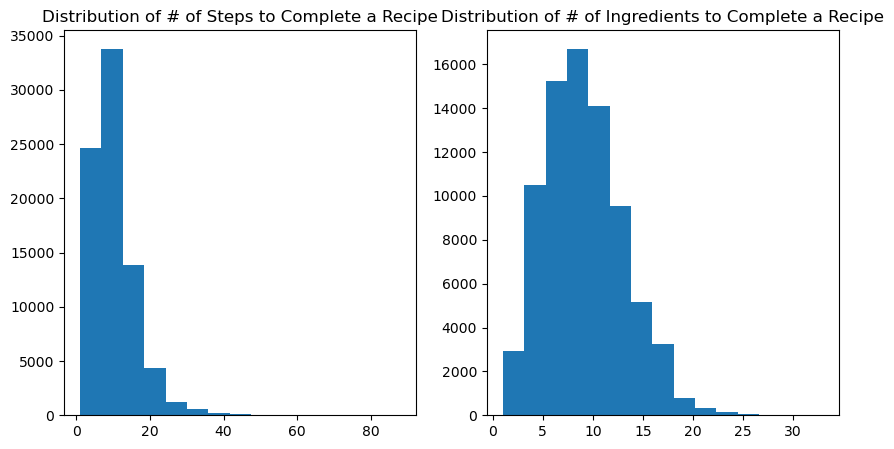

In [143]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.hist(food_data['n_steps'], bins=15)
ax.set_title('Distribution of # of Steps to Complete a Recipe')
ax = fig.add_subplot(122)
ax.hist(food_data['n_ingredients'], bins=15)
ax.set_title('Distribution of # of Ingredients to Complete a Recipe')
plt.show()

### Baseline Model

__Description__: As mentioned, I will be using **n_ingredients** and **n_steps** from the original dataset as initial features for my baseline model. While there are no categorical features so feature encoding will not be necessary here, there is no upper bound for the number of ingredients and number of steps since they are both <i>ordinal discrete</i> variables so some transformation might be required.


__Feature Transformations__: First step of transformation was transforming the columns in a dataset with using *ColumnTransformer* with *FunctionTransformer(np.log)*and *MinMaxScaler()*.
We transform data in *n_steps* and *n_ingredients* into log of its data in order to make them to resemble to normal distribution. Then, we normalized the values in two columns with using *MinMaxScaler()* so that they can have the same scale for better prediction. 


__Hyperparameters Used__: 
We used *GridSearchCV* to predict the ideal hyperparamters for criterion, max_depth of tree, and min_samples_plits.
Initially we used hyperparatmers with broad range *(ex.clf__max_depth' : [1, 30, 50, 100, 200])*, and we minimized the range by running the GridSearch for several times. After Several times, we got to conclusion with ```{'clf__criterion': 'absolute_error','clf__max_depth': 10, 'clf__min_samples_split': 20}```

After the *GridSearchCV*, we use the ideal parameters to train and test the data with *DecisionTreeRegressor* and fit the data after.


__Performance of the model__:
As we have have higher train mean absolute error than the test mean absolute error, we can tell that the data is underfitting ```(X_train = 98.6017887834999, X_test = 70.7474696839492)```. We also tried to fit the data with grid search and cross validation, and the gap distance between train data and test data did not get closed up. However, the gap between the train and test data are not too far off, and we can predict that there is no error for traing and testing regression. The possible reason for the slight gap between two might caused by our two features that we used for training and testing the regression are insufficient to explain the data and predict the minute.

In [144]:
### Helper Functions
def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred) ** 2))

def normalized_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    target_range = np.max(y_true) - np.min(y_true)
    return rmse / target_range

In [145]:
#train-test split, here I used the default of 75% train and 25% test
X = food_data.drop('minutes', axis=1)
y = food_data['minutes']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59127, 6), (19710, 6), (59127,), (19710,))

(array([  545.,  1893.,  5689., 10614., 14570., 15147., 13376.,  8655.,
         5329.,  3019.]),
 array([ 0.        ,  3.14594978,  6.29189955,  9.43784933, 12.58379911,
        15.72974889, 18.87569866, 22.02164844, 25.16759822, 28.31354799,
        31.45949777]),
 <BarContainer object of 10 artists>)

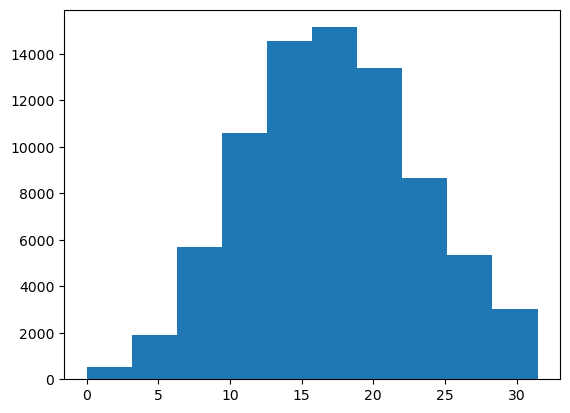

In [146]:
plt.hist(np.sqrt(food_data['calories']))

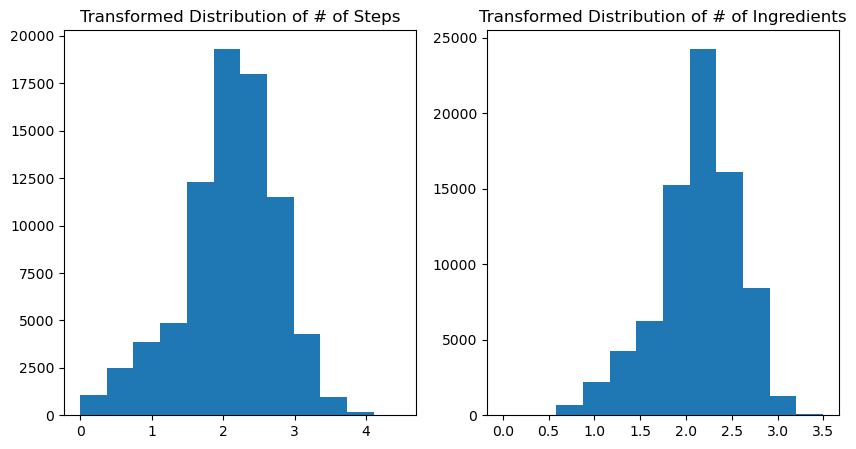

In [147]:
### Visualization of the log-transformation to make distribution more "normal" or "symmetrical"
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.hist(np.log(food_data['n_steps']), bins=12)
ax.set_title('Transformed Distribution of # of Steps')
ax = fig.add_subplot(122)
ax.hist(np.log(food_data['n_ingredients']), bins=12)
ax.set_title('Transformed Distribution of # of Ingredients')
plt.show()

In [148]:
import multiprocessing
multiprocessing.cpu_count()

10

In [149]:
baseline = Pipeline(
    [
        ('column_transform', ColumnTransformer(
            [
                ('log_transform', FunctionTransformer(np.log), ['n_steps', 'n_ingredients']),
                ('normalize', MinMaxScaler(), ['n_steps','n_ingredients'])
            ], remainder='drop'
        )),
        ('clf', DecisionTreeRegressor(random_state=42, criterion = 'absolute_error', max_depth = 10, min_samples_split= 20))
    ]
)
baseline.fit(X_train, y_train)
# hyperparam_grid = {
#     'clf__max_depth' : [2,3,5,10,25,50,100],
#     'clf__criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
#     'clf__min_samples_split' : [2,5,10,20,50,100,200]
# }

# gridsearch = GridSearchCV(baseline, hyperparam_grid, cv=5, verbose=1)
# gridsearch.fit(X_train, y_train)

Pipeline(steps=[('column_transform',
                 ColumnTransformer(transformers=[('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['n_steps', 'n_ingredients']),
                                                 ('normalize', MinMaxScaler(),
                                                  ['n_steps',
                                                   'n_ingredients'])])),
                ('clf',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                                       min_samples_split=20,
                                       random_state=42))])

In [150]:
mean_absolute_error(y_train, baseline.predict(X_train))

86.417660290561

In [151]:
mean_absolute_error(y_test, baseline.predict(X_test))

92.89571283612379

In [152]:
mean_absolute_percentage_error(baseline.predict(X_train), y_train)

3.1247547485232463

In [153]:
mean_absolute_percentage_error(baseline.predict(X_test), y_test)

3.36226235889115

In [154]:
baseline.score(X_train, y_train)

-0.00026516007366694794

In [155]:
#
baseline.score(X_test, y_test)

-0.0007828445554518559

### Final Model

To improve the final model, we incorporated two new features: **text length** feature and **TF-IDF** analysis feature.  

__Feature Engineering__: 

Our final model incorporated two new features. First of all, we created a **'steps_length'** column by calculating the length of the text in the **'steps'** column, which can be a proxy for recipe complexity. We assumed that the longer texts describing the steps required for a reicipe, the more detailed or complex preparation processes it may indicate, potentially leading to longer cooking times. 

Secondly, we used TF-IDF Vectorization on the **'ingredients** column to transform the textual ingredient data into a structured format. This method will help in quantifying the uniqueness and importance of each ingredient in the context of the entire dataset. Ingredients that are unique or less common might be associated with more complex recipes, thus longer cooking times.

__Model Building__: 

We used a more sophisticated model for this final model by incorporating RandomForestRegressor to capture more complex relationships in the data than a simple DecisionTreeRegressor. 



In [156]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error

In [157]:
def get_document_length(cols):
    df_copy = pd.DataFrame(cols)
    for col in df_copy.columns:
        df_copy[col] = df_copy[col].apply(lambda x: len(x.split()))
    return df_copy

In [158]:
# New length feature for recipe steps
# food_data = transform_text(food_data, ['ingredients', 'steps'])
# food_data['steps_length'] = food_data['steps'].apply(len)

In [159]:
#Data Preparation; Here, I used the default of 75% train and 25% test
W = food_data[['n_steps', 'n_ingredients', 'ingredients', 'calories','steps']]
z = food_data['minutes'].astype(np.float64)
W_train, W_test, z_train, z_test = train_test_split(W, z, random_state=42)
W_train.shape, W_test.shape, z_train.shape, z_test.shape

((59127, 5), (19710, 5), (59127,), (19710,))

(array([  26.,   22.,   28.,   44.,   52.,   64.,   74.,   70.,   89.,
          76.,  102.,  100.,  135.,  134.,  198.,  188.,  216.,  238.,
         272.,  310.,  330.,  404.,  408.,  510.,  538.,  617.,  672.,
         721.,  683.,  806.,  836.,  882.,  947.,  972., 1046., 1067.,
        1078., 1207., 1289., 1290., 1374., 1390., 1367., 1445., 1420.,
        1470., 1457., 1554., 1526., 1567., 1527., 1501., 1555., 1572.,
        1594., 1496., 1439., 1542., 1512., 1409., 1502., 1543., 1482.,
        1295., 1359., 1371., 1281., 1192., 1207., 1144., 1020.,  985.,
         973.,  898.,  913.,  913.,  773.,  784.,  705.,  691.,  677.,
         654.,  610.,  542.,  547.,  497.,  488.,  484.,  442.,  388.,
         385.,  393.,  358.,  333.,  310.,  306.,  251.,  233.,  232.,
         218.]),
 array([ 0.        ,  0.31459498,  0.62918996,  0.94378493,  1.25837991,
         1.57297489,  1.88756987,  2.20216484,  2.51675982,  2.8313548 ,
         3.14594978,  3.46054475,  3.77513973,  4.089734

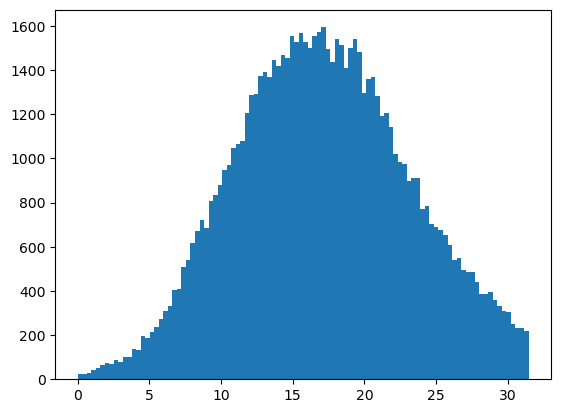

In [160]:
plt.hist(np.sqrt(food_data['calories']), bins=100)

In [161]:
#feature transformations
column_trans = ColumnTransformer([
        ('transform_ordinal', Pipeline(
            [
                ('log_transform', FunctionTransformer(np.log)),
                ('normalize_ordinal', MinMaxScaler())
            ]
        ), ['n_steps', 'n_ingredients']),
        ('transform_calories', Pipeline(
            [
                ('log_transform2', FunctionTransformer(np.sqrt)),
                ('normalize_ordinal2', MinMaxScaler())
            ]
        ), ['calories']),
        # ('transform_document_length', Pipeline(
        #     [
        #         ('get_document_length', FunctionTransformer(get_document_length)),
        #         ('normalize_length', MinMaxScaler())
        #     ]
        # ), ['steps', 'ingredients']),
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=100), 'steps'),
    ], remainder='drop')

In [162]:
column_trans.fit_transform(W_train).shape

(59127, 103)

In [163]:
# Define the pipeline
final_pl = Pipeline([
    ('preprocessor', column_trans),
    ('model', RandomForestRegressor(random_state=42, criterion='squared_error',
                                    max_depth=6, min_samples_split=30))
])
final_pl.fit(W_train, z_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('transform_ordinal',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('normalize_ordinal',
                                                                   MinMaxScaler())]),
                                                  ['n_steps', 'n_ingredients']),
                                                 ('transform_calories',
                                                  Pipeline(steps=[('log_transform2',
                                                                   FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                  ('normalize_ordinal2',
                                                                   MinMaxScaler())]),
                                                  ['calories']),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_features=100,
                                                                  stop_words='english'),
                                                  'steps')])),
                ('model',
                 RandomForestRegressor(max_depth=6, min_samples_split=30,
                                       random_state=42))])

In [164]:
# # # param_grid = {
# # #     'model__n_estimators': [100, 200, 500],
# # #     'model__max_depth': [10, 20, 30, 50, 100],  # None means no limit on the depth of the tree
# # #     'model__criterion': ['squared_error', 'absolute_error'],  # Criteria for splitting
# # #     'model__min_samples_split': [2, 10, 15, 20, 50]  # Minimum number of samples required to split an internal node
# # # }

# param_grid = {
#     'model__max_depth': [4, 5, 6],  # None means no limit on the depth of the tree
#     'model__min_samples_split': [15, 30, 50]  # Minimum number of samples required to split an internal node
# }

# # # Grid search with cross-validation
# grid_search = GridSearchCV(final_pl, param_grid, cv=5, verbose=5, n_jobs=3)
# grid_search.fit(W_train, z_train)

In [165]:
mean_absolute_error(z_train, final_pl.predict(W_train))

90.87995849444408

In [166]:
mean_absolute_error(z_test, final_pl.predict(W_test))

115.9155515445313

In [167]:
final_pl.score(W_train, z_train)

0.7760466113090686

## Fairness Analysis
---
For our fairness analysis, we asked the question, **"does our final model perform better for recipes that take longer than an hour than it does for recipes that take 50 minutes or less?"** To test this, we ran a permutation test by shuffling the minutes of **Group X** where recipes take *longer than 50 minutes* to make and **Group Y** where recipes take *50 minutes or less*. 

We chose **RMSE** as our evaluation metric as it provides a somewhat clear measure of the average error in our predictions with a regression model. 

- **Null Hypothesis**: The model's performance, as measured by RMSE, is the *same* for both Group X and Group Y. Any observed differences in RMSE between the two groups are due to random chance.

- **Alternative Hypothesis**: The model's performance, as measured by RMSE, *differs* between Group X and Group Y. 

- **Test Statistic**: We used the *absolute difference in RMSE* between Group X and Group Y.
  
- **Significance Level**: 0.05

To perform the permutation test, we calculated the inital RMSE for each group using the actual data. We then shuffled the `minutes` values between two groups, and the RMSEs are recalculated for these permuted groups. 

**Permutation Testing Result**:
Our permutation test resulted in a p-value of **0.071**, which is *greater* than our significance level, 0.05. Therefore, we have a strong evidence to ***fail to reject*** the null hypothesis. This ***suggests*** that the model's performance is the same across the two groups: recipes that take longer than an hour and those that take 50 minutes or less. 

However, we can not be completely certain when drawing conclusions, therefore these findings merely indicate that our model is **reasonably fair based on the specific criteria and groups tested**; they do not represent a firm conclusion for entire unseen data. 


In [168]:
def rmse(y_actual, y_pred):
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [169]:
predictions = final_pl.predict(W)

group_x = food_data[food_data['minutes'] > 50].reset_index(drop=True)
group_y = food_data[food_data['minutes'] <= 50].reset_index(drop=True)

rmse_x_initial = rmse(group_x['minutes'], predictions[:len(group_x)])
rmse_y_initial = rmse(group_y['minutes'], predictions[-len(group_y):])
rmse_diff_initial = abs(rmse_x_initial - rmse_y_initial)


In [170]:
n_permutations = 1000
count = 0
rmse_diffs_lst= []

for _ in range(n_permutations):
    # Permuting the minutes
    all_min = np.concatenate((group_x['minutes'], group_y['minutes']))
    np.random.shuffle(all_min)

    # New groups after permutation
    permuted_x = all_min[:len(group_x)]
    permuted_y = all_min[len(group_x):]

    # Recalculate RMSE for permuted groups
    rmse_x_permuted = rmse(permuted_x, predictions[:len(group_x)])
    rmse_y_permuted = rmse(permuted_y, predictions[-len(group_y):])
    rmse_diff_permuted = abs(rmse_x_permuted - rmse_y_permuted)
    rmse_diffs_lst.append(rmse_diff_permuted)

    if rmse_diff_permuted >= rmse_diff_initial:
        count += 1

p_value = count / n_permutations

if p_value < 0.05:
    conclusion = "unfair"
else:
    conclusion = "fair"

print(f"P-value: {p_value}, Conclusion: Model is {conclusion}")

P-value: 0.059, Conclusion: Model is fair


The histogram below offers a visualization of the RMSE differences obtained during the permutation iterations. The red vertical line indicates the *observed* RMSE difference. 

In [171]:
fig_perm = px.histogram(rmse_diffs_lst, nbins=30, labels={'value': 'RMSE Difference'}, title='Permutation Test RMSE Differences')
fig_perm.add_vline(x=rmse_diff_initial, line_width=2, line_color="red", annotation_text="Observed RMSE Difference")
fig_perm.show()

In [172]:
fig_perm.write_html('fig_perm.html', include_plotlyjs='cdn')